In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# declare a Base using 'automap_base()'
Base = automap_base()

In [6]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.

period_start = dt.date(2017,8,23) - dt.timedelta(days=365)
period_start

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores

last_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= period_start).all()

last_year_data[0:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [13]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(last_year_data, columns = ['Date', 'Precipitation'])
prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [14]:
# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by=['Date']).set_index(['Date'])
prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


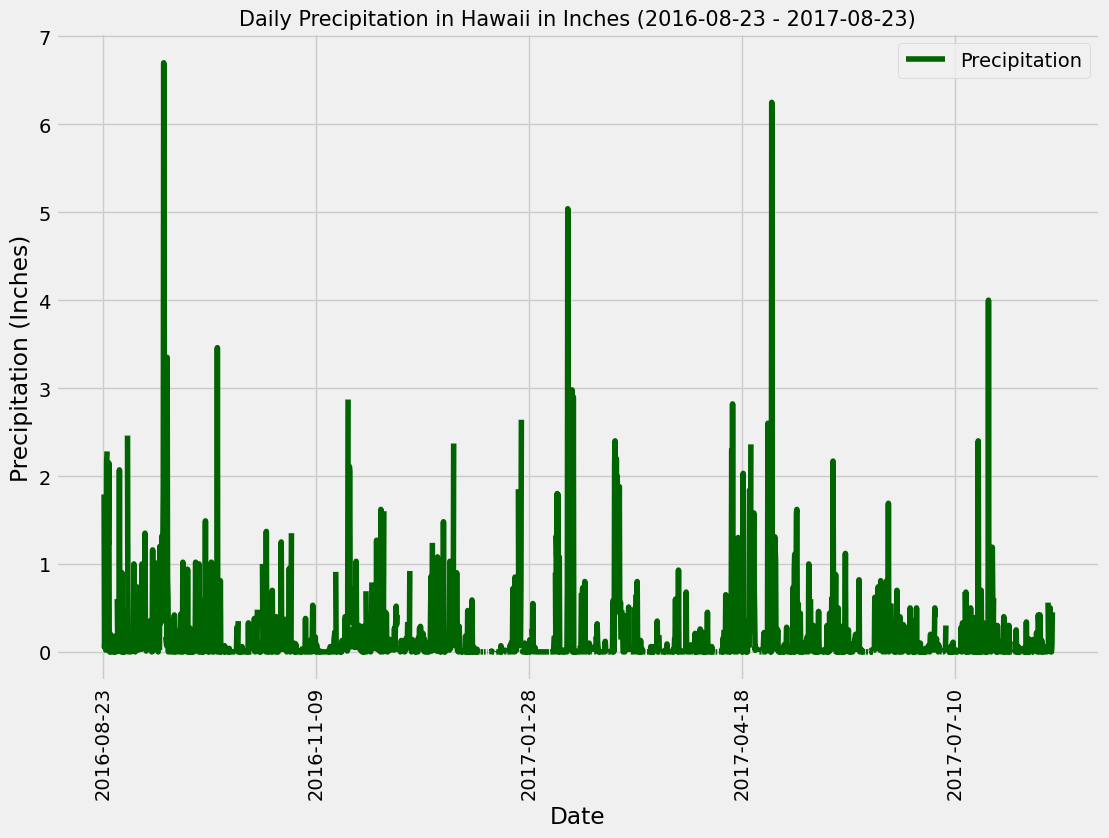

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(color = 'darkgreen', rot=90, figsize=[12,8])

plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title(f"Daily Precipitation in Hawaii in Inches ({period_start} - {most_recent_date})", size=15)
plt.savefig("precipitation_plot.png")
plt.show()

In [42]:
#Resampling requires input as index
df = prcp_df.copy()
df.index = pd.to_datetime(df.index)
median_df = df.resample('w').max()
median_df.head()

,Precipitation
Date,
2016-08-28,2.28
2016-09-04,2.46
2016-09-11,1.35
2016-09-18,6.70
2016-09-25,1.02


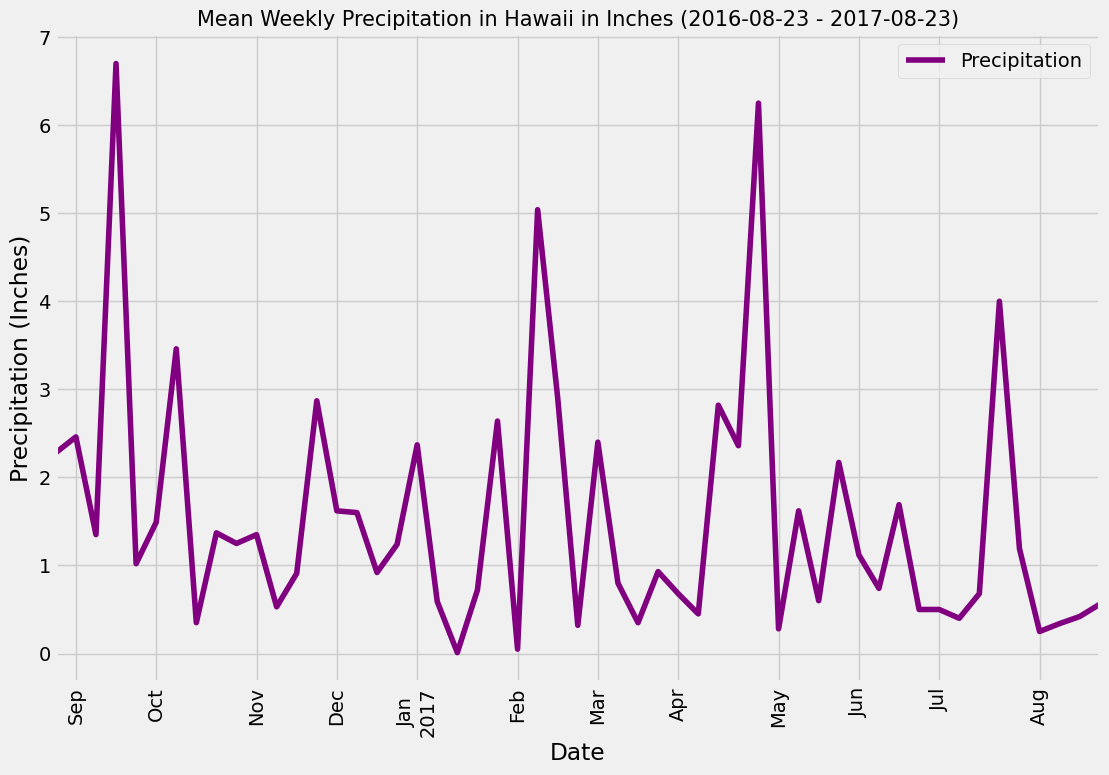

In [43]:
# Use Pandas Plotting with Matplotlib to plot the data
median_df.plot(color = 'purple', rot=90, figsize=[12,8])

plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title(f"Mean Weekly Precipitation in Hawaii in Inches ({period_start} - {most_recent_date})", size=15)
plt.savefig("precipitation_plot.png")
plt.show()

Precipitation    AxesSubplot(0.08,0.07;0.87x0.81)
dtype: object

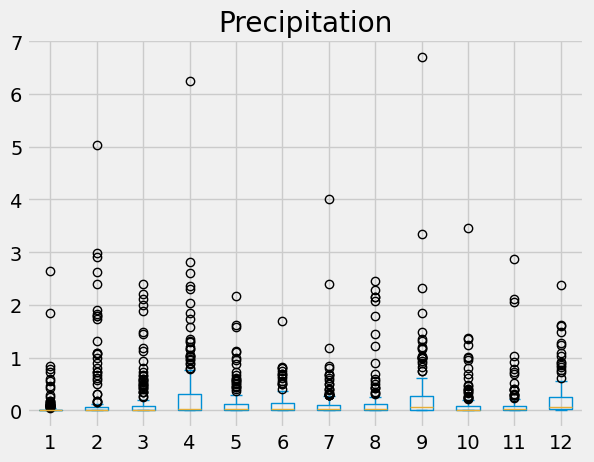

In [64]:
from datetime import datetime
get_months = df.reset_index()
get_months["Month"] = get_months.Date.map(lambda x: x.month)
get_months.plot.box(by="Month")

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.Precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
n_stations = session.query(Station.station).count()
n_stations

9

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
station_activity[0:5]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity[0][0]
most_active_station

'USC00519281'

In [22]:
most_active_station_temperatures = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active_station)
most_active_station_temperatures

In [23]:
most_active_temp_df = pd.DataFrame(most_active_station_temperatures, columns = ['Station', 'Temperature'])
most_active_temp_df.head()

,Station,Temperature
0,USC00519281,70.0
1,USC00519281,62.0
2,USC00519281,74.0
3,USC00519281,75.0
4,USC00519281,74.0


In [24]:
most_active_temp_df.Temperature.describe()

count    2772.000000
mean       71.663781
std         4.357642
min        54.000000
25%        69.000000
50%        72.000000
75%        74.000000
max        85.000000
Name: Temperature, dtype: float64

In [25]:
lowest_temp = most_active_temp_df.Temperature.min()
highest_temp = most_active_temp_df.Temperature.max()
average_temp = most_active_temp_df.Temperature.mean()

print(lowest_temp, highest_temp, average_temp)

54.0 85.0 71.66378066378067


In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
MAS_year_query = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= period_start).all()

MAS_annual_temp_df = pd.DataFrame(MAS_year_query, columns = ['Station', 'Temperature'])
MAS_annual_temp_df

,Station,Temperature
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0
...,...,...
347,USC00519281,77.0
348,USC00519281,77.0
349,USC00519281,76.0
350,USC00519281,76.0


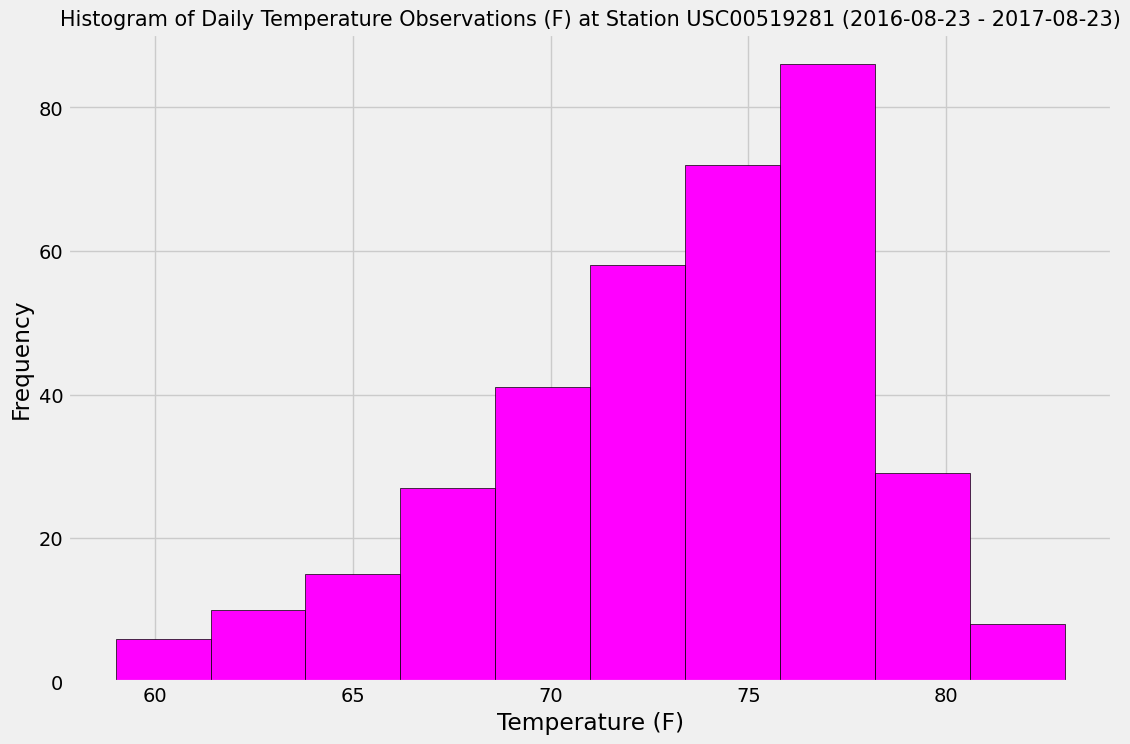

In [27]:
MAS_annual_temp_df.Temperature.plot.hist(figsize = [12,8], color = 'magenta', edgecolor = 'black')

plt.title(f"Histogram of Daily Temperature Observations (F) at Station {most_active_station} ({period_start} - {most_recent_date})", size = 15)
          
plt.xlabel("Temperature (F)")
plt.savefig("temperature_histogram.png")
plt.show()

# Close Session

In [28]:
# Close Session
session.close()